# imports

In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packag

In [2]:
e = exp.load('iter_exps10', experiment_location='experiments', datadir='Mdata')
np.mean(e.trials[0].LLs)

0.10018215

In [3]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

In [6]:
dirsel_neurons = [0, 2, 63, 87] + [1, 3, 36, 89]
print(dirsel_neurons)
# get the top spikes for the direction selective neurons
top_spikes = np.argsort(dataset.robs[:,dirsel_neurons], axis=0)[-10:,:]

results = []
for ni in range(len(dirsel_neurons)):
    results.append(predict.predict(e.trials[0].model, dataset=dataset[top_spikes[:,ni]], calc_jacobian=True, verbose=False))

[0, 2, 63, 87, 1, 3, 36, 89]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


Neuron readout weights shape (98, 36)
Num layers 3
--> 0 2
Network 0 Layer 0 Jacobian shape (10, 2, 36, 6, 504) Neuron weights shape (98, 36)
Layer readout weights shape (2, 36)
Layer Jacobians shape (2, 36, 6, 504)
--> 2 18
Network 0 Layer 1 Jacobian shape (10, 16, 36, 6, 504) Neuron weights shape (98, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (16, 36, 6, 504)
--> 18 34
Network 0 Layer 2 Jacobian shape (10, 5, 16, 36, 1, 504) Neuron weights shape (98, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (5, 16, 36, 1, 504)
iters 5
Neuron readout weights shape (98, 36)
Num layers 3
--> 0 2
Network 0 Layer 0 Jacobian shape (10, 2, 36, 6, 504) Neuron weights shape (98, 36)
Layer readout weights shape (2, 36)
Layer Jacobians shape (2, 36, 6, 504)
--> 2 18
Network 0 Layer 1 Jacobian shape (10, 16, 36, 6, 504) Neuron weights shape (98, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (16, 36, 6, 504)
--> 18 34
Network 0 Layer 2 Jacobian shape (10

/tmp/ipykernel_129327/78920006.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(subunits*2,1))


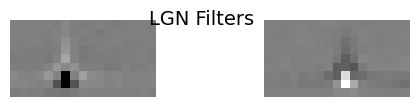

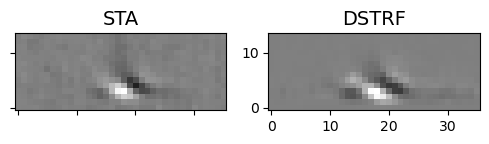

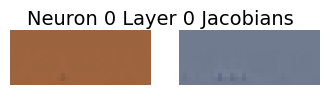

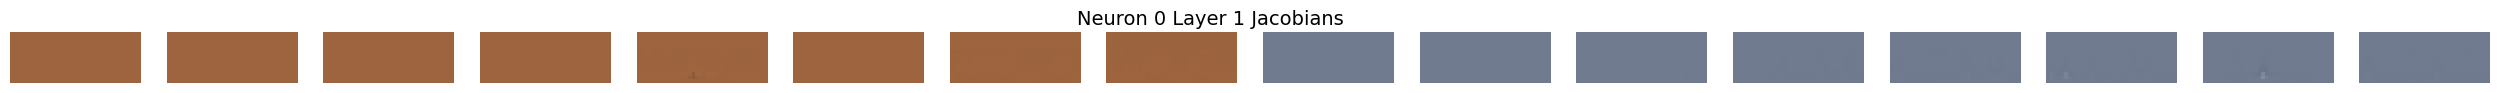

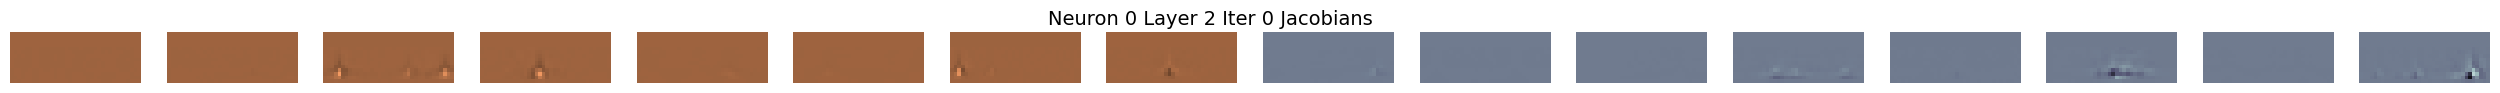

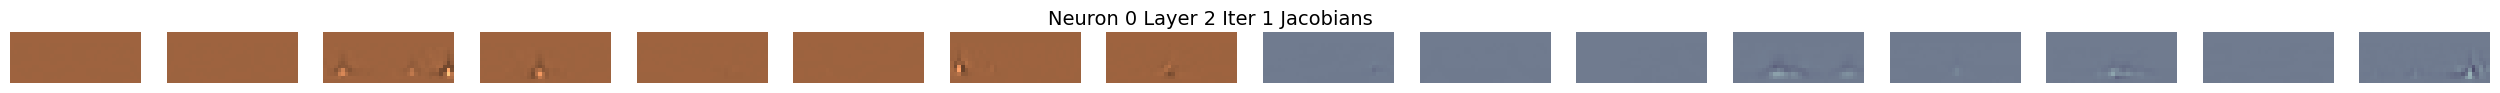

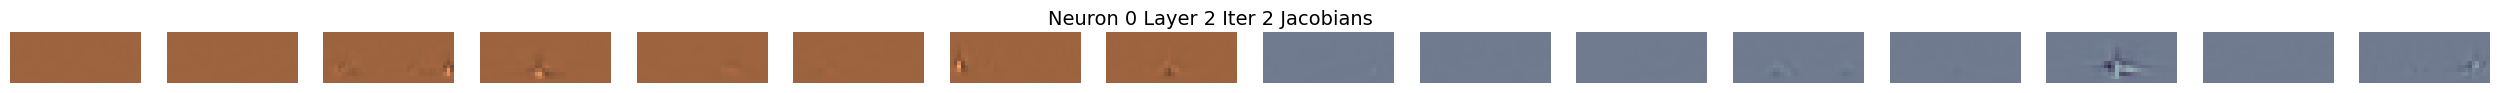

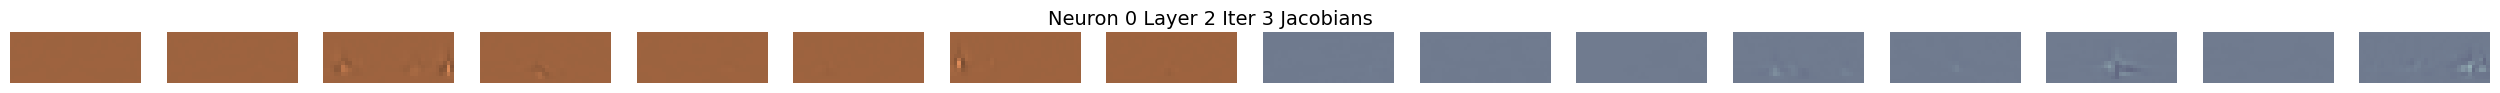

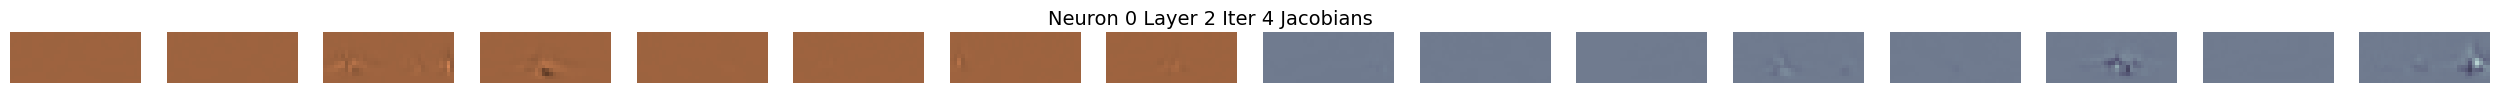

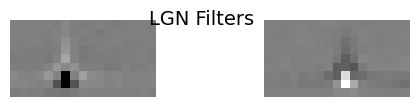

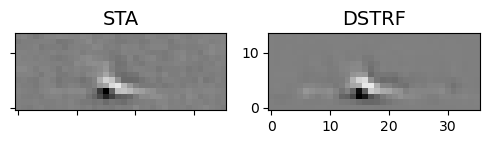

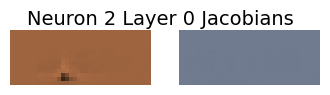

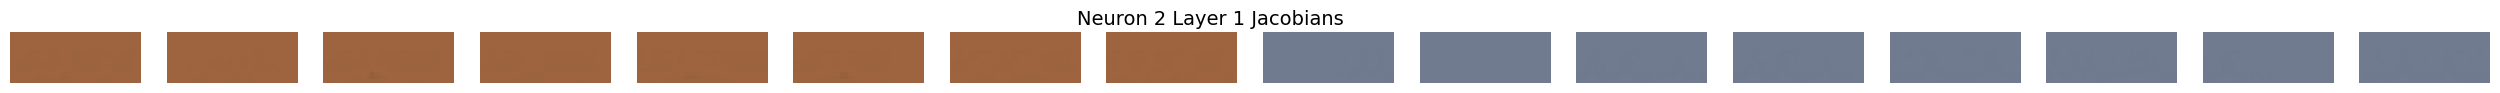

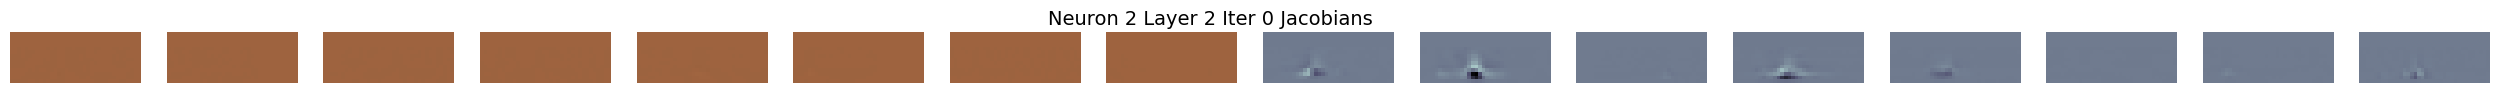

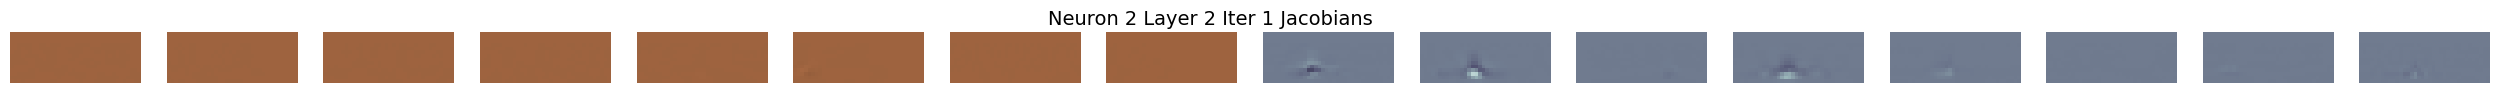

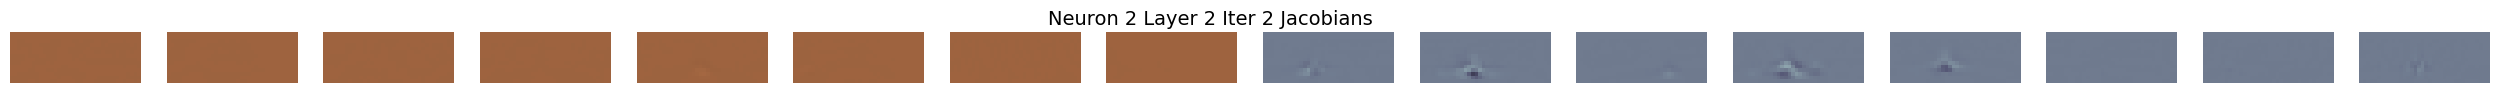

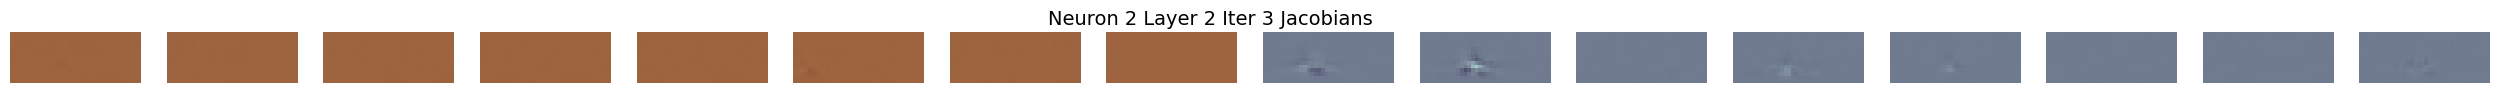

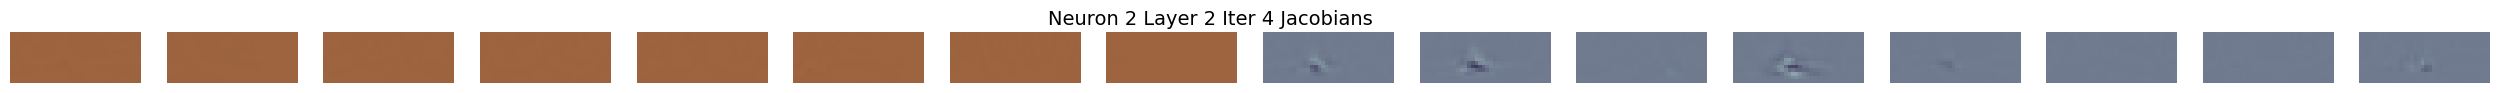

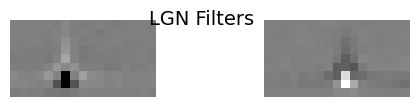

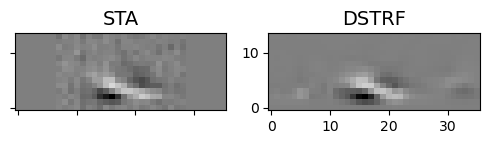

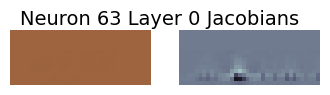

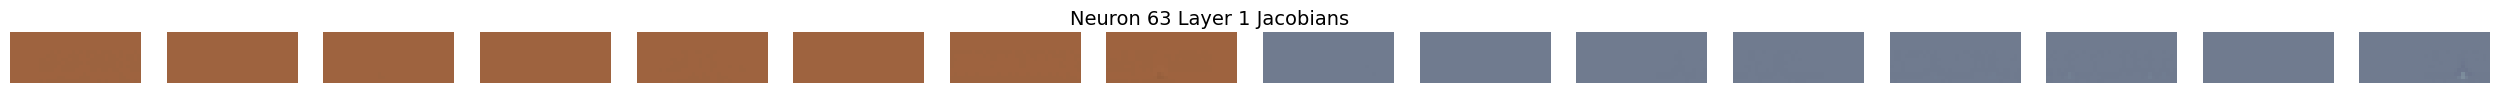

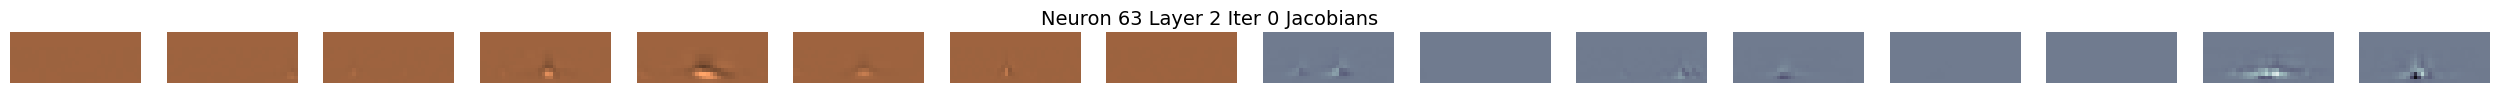

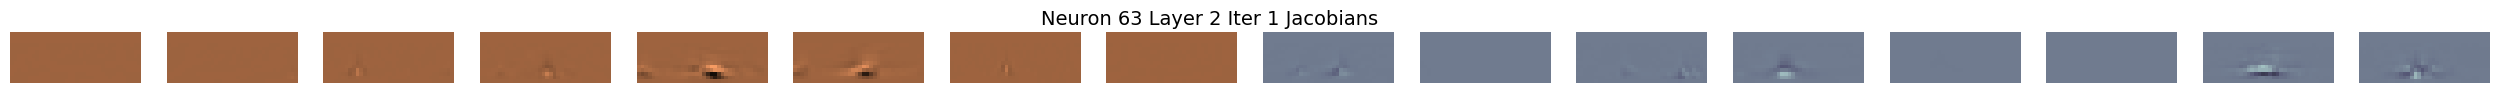

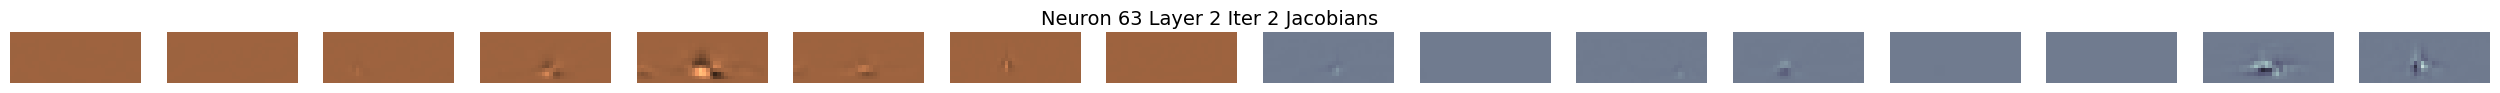

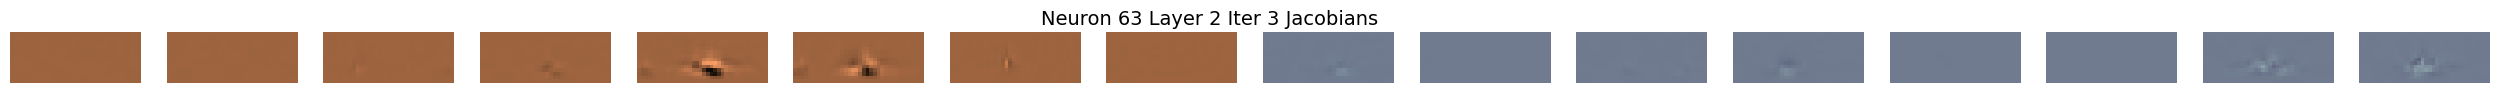

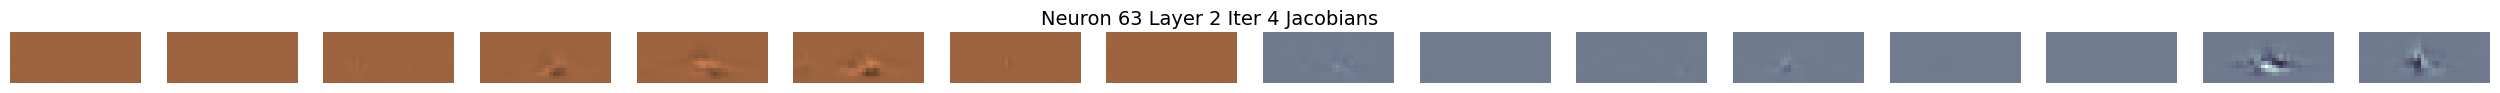

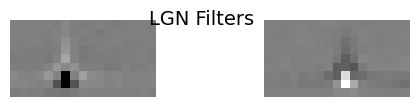

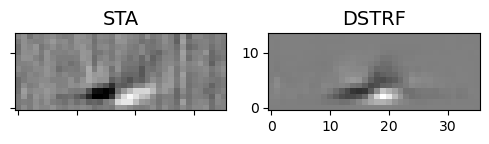

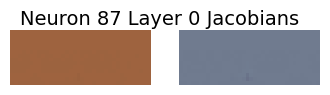

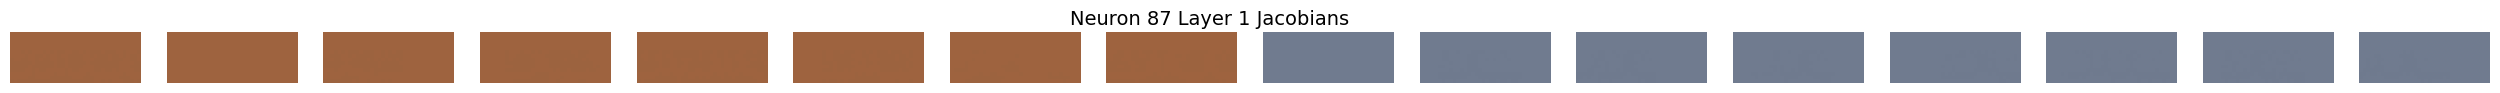

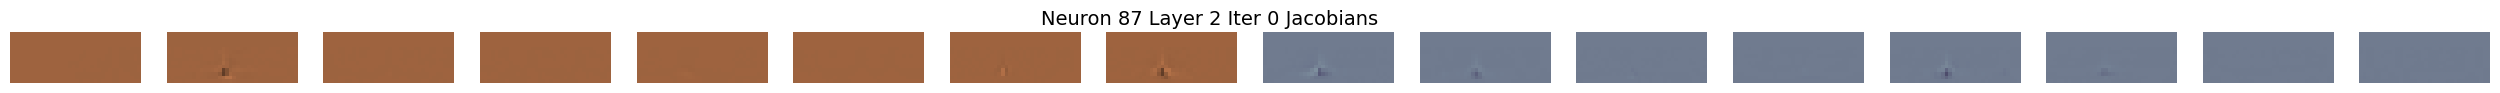

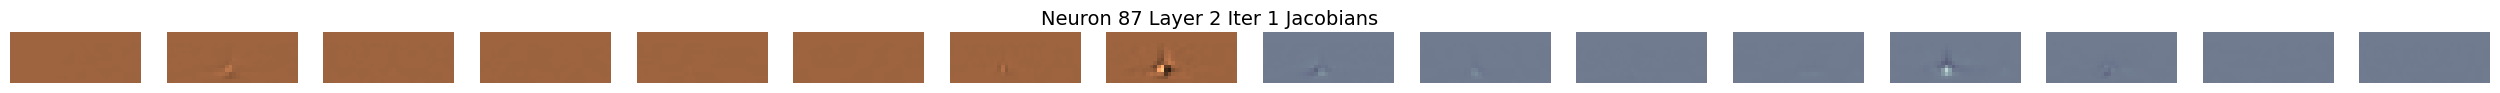

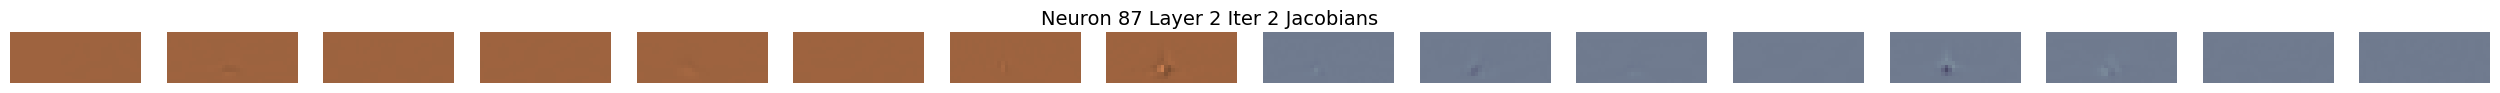

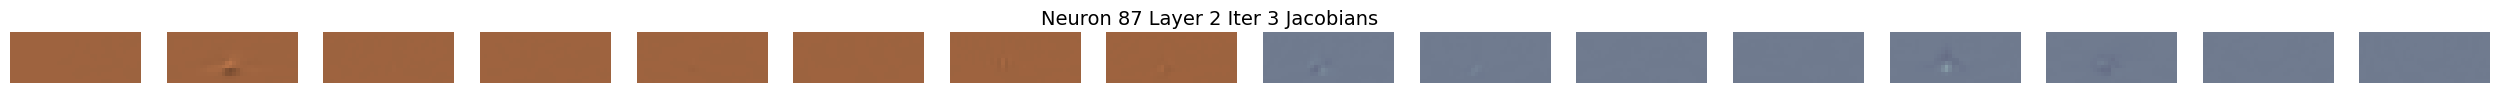

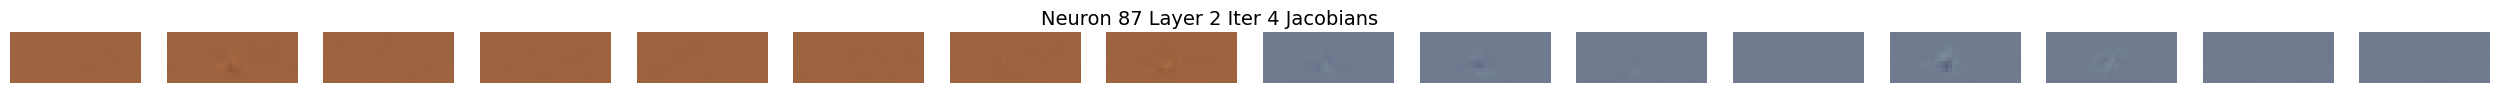

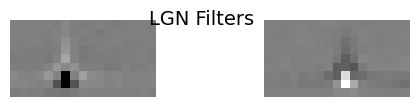

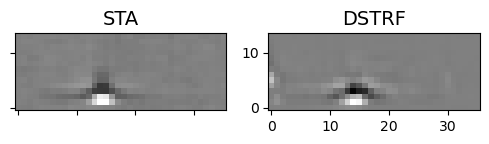

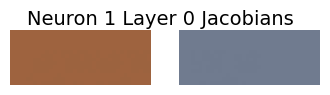

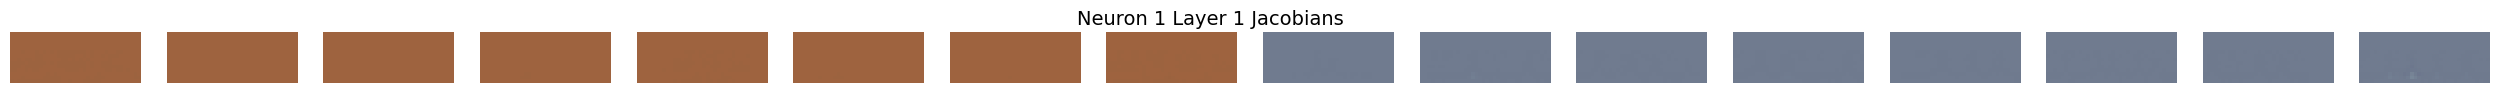

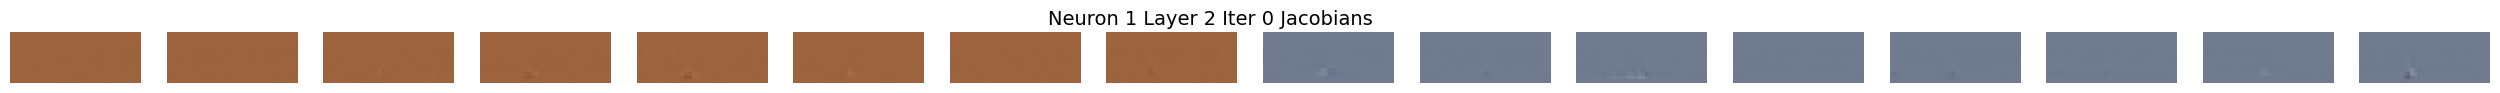

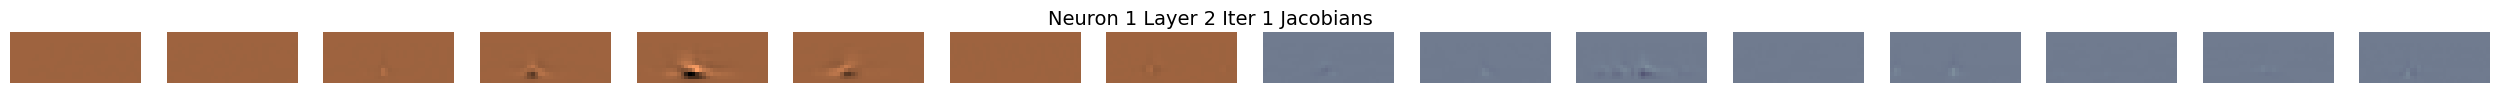

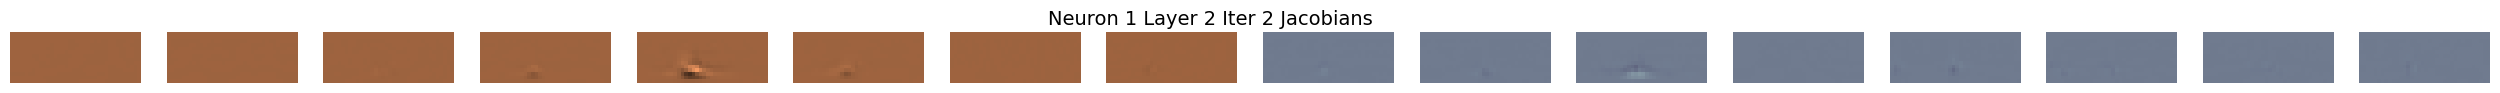

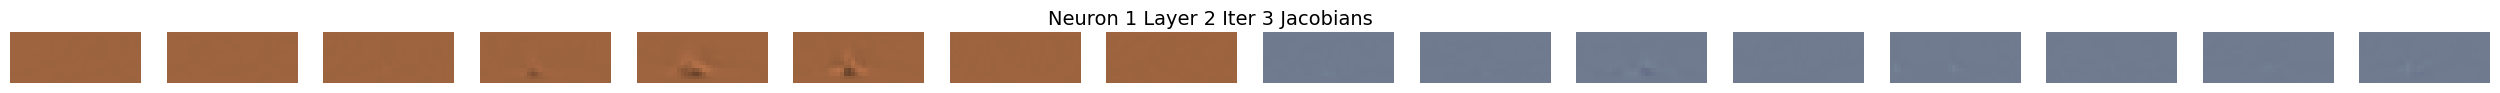

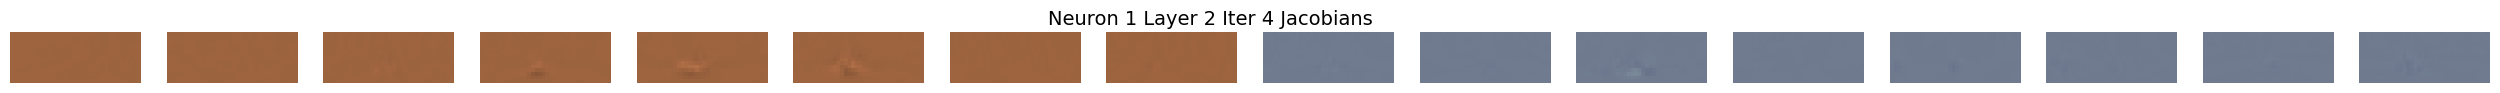

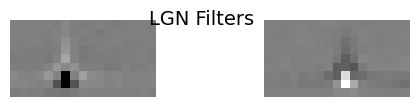

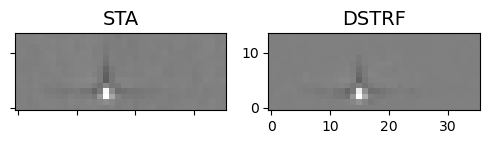

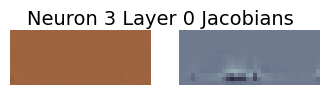

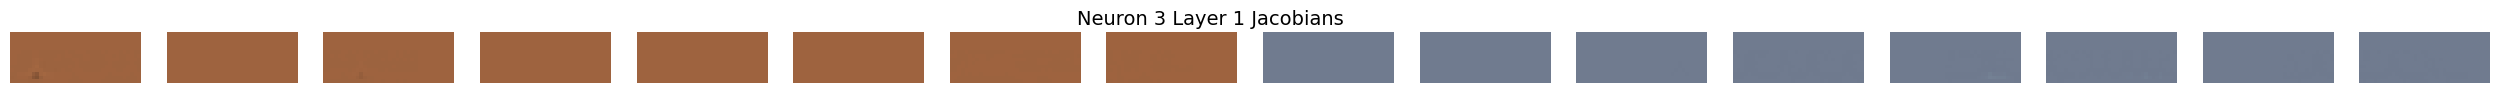

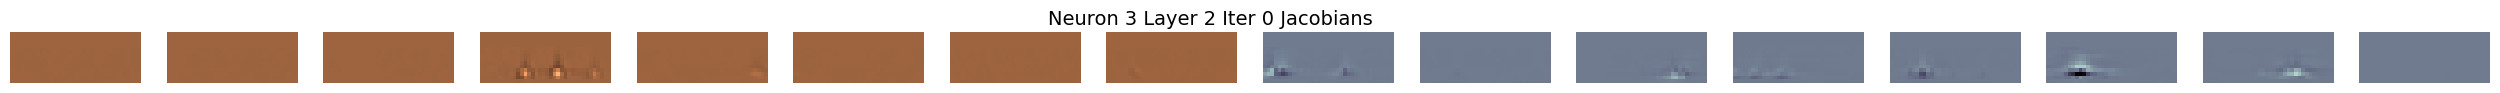

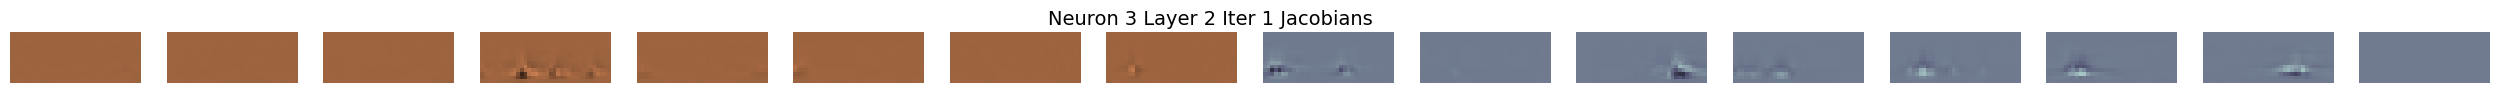

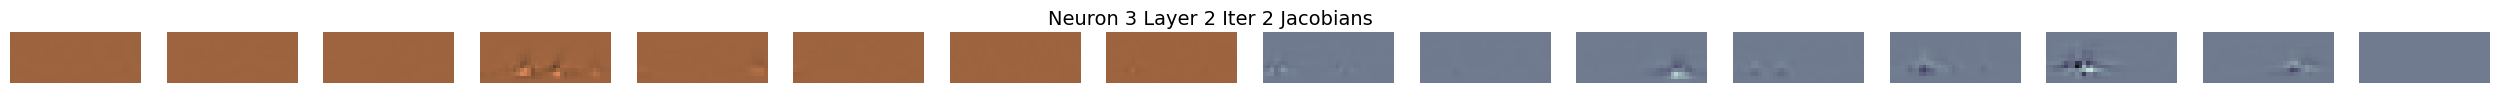

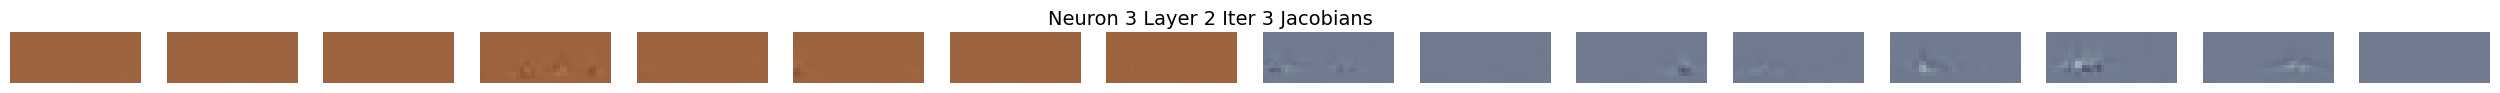

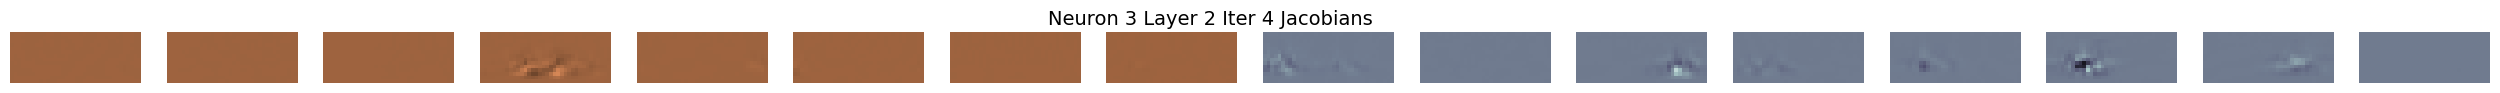

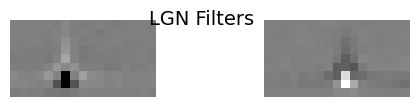

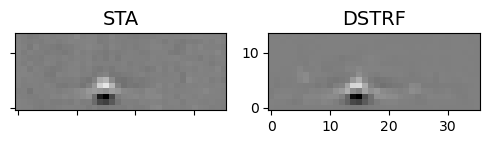

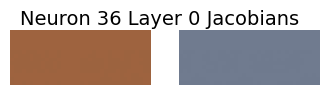

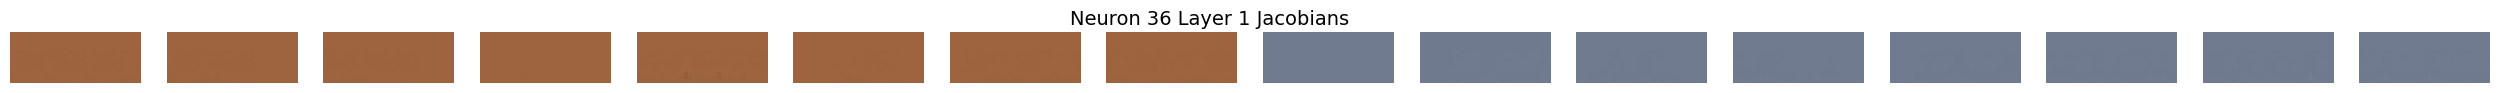

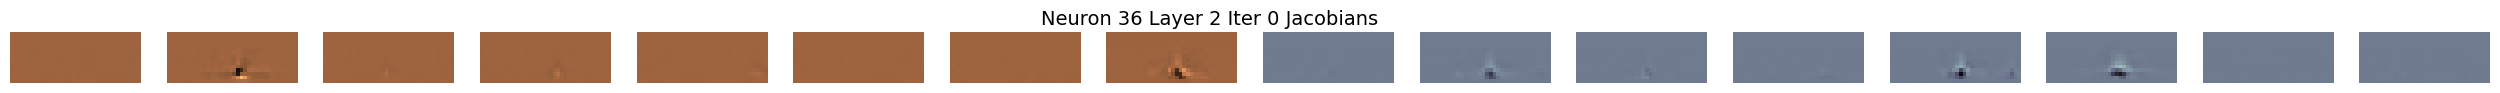

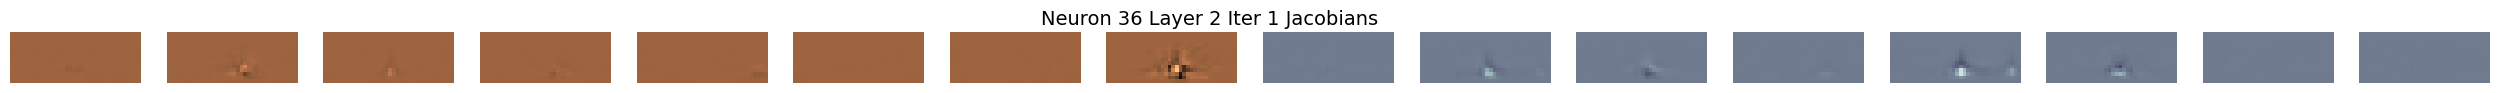

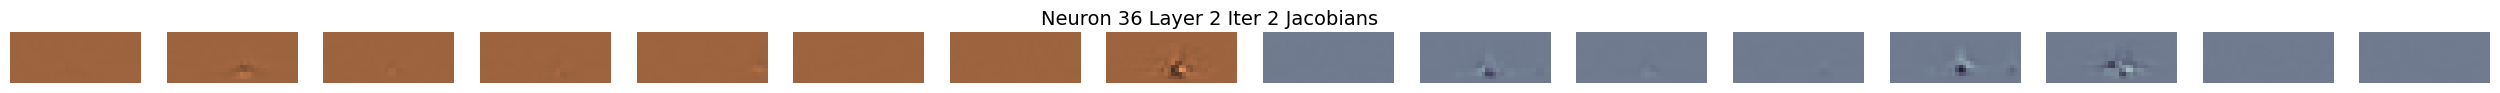

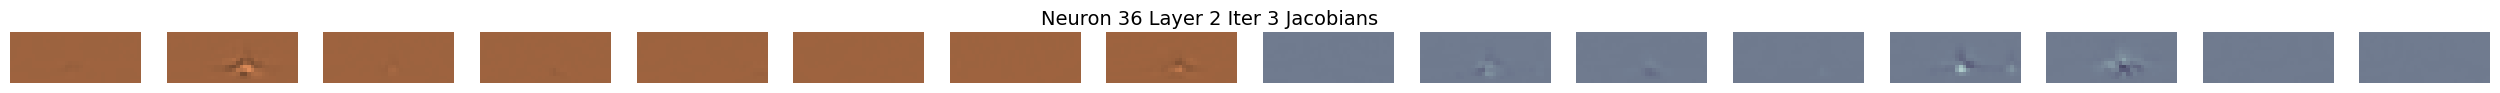

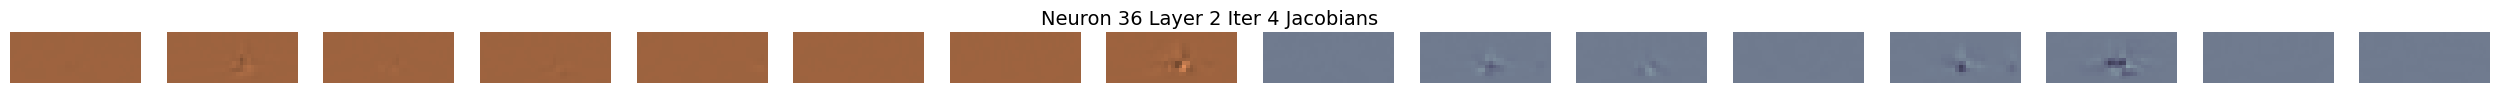

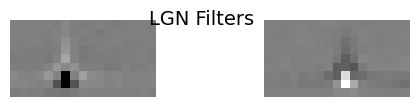

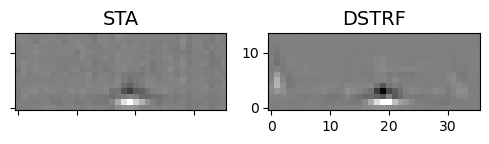

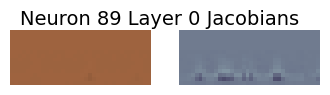

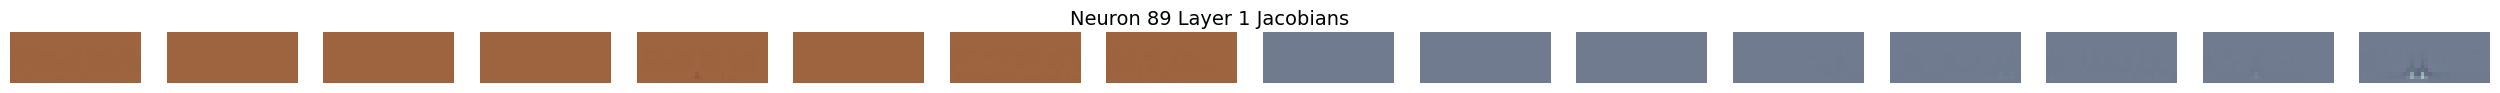

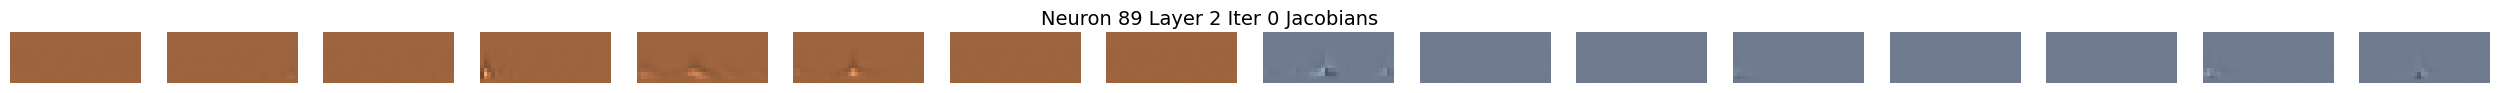

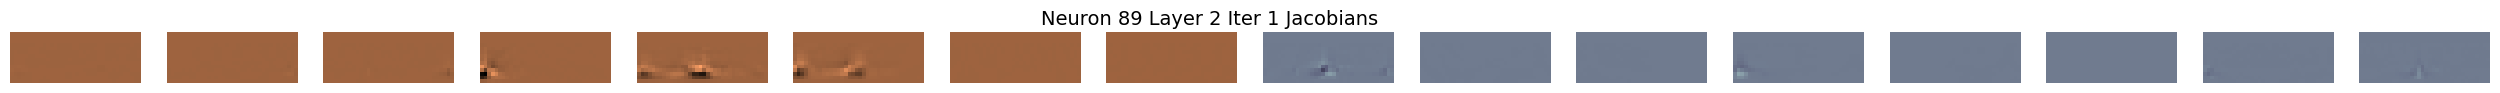

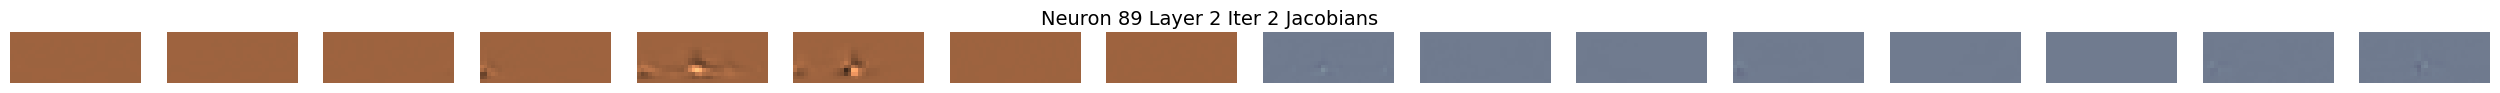

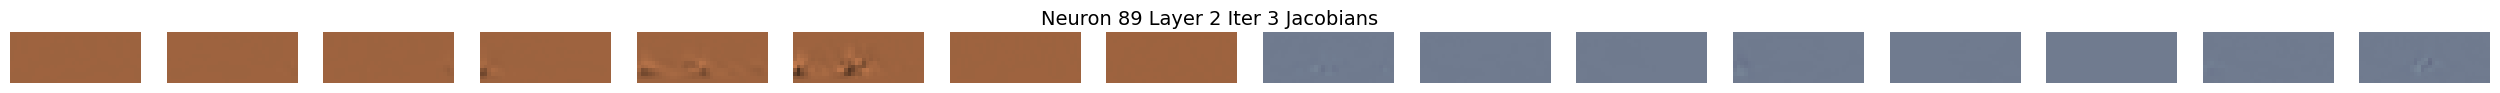

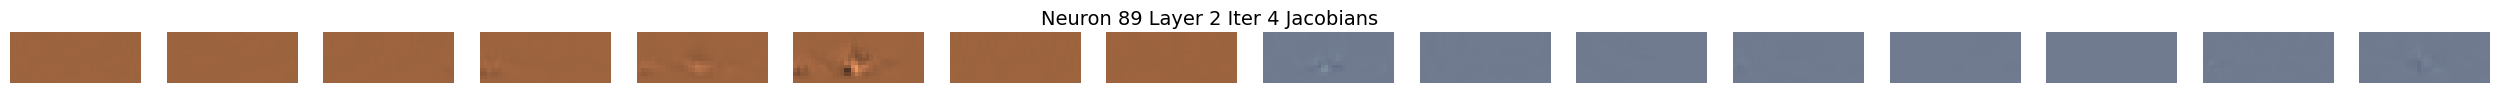

In [7]:
model = e.trials[0].model
neuron_readout_weights = model.networks[-1].layers[-1].weights[:,:,dirsel_neurons]
# normalize the weights
neuron_readout_weights = neuron_readout_weights / np.max(np.abs(neuron_readout_weights))

weighted_jacobians = []
weighted_jacobian_maxes = []
for neuron_idx in range(len(dirsel_neurons)):
    weighted_jacobians_neuron = []
    weighted_jacobian_max_neuron = 0
    neuron = dirsel_neurons[neuron_idx]
    jacobians = results[neuron_idx].jacobians

    neuron_readout_weights = model.networks[-1].layers[-1].weights[:,:,neuron_idx]

    start_weight_pos = 0
    print('Neuron readout weights shape', neuron_readout_weights.shape)
    for ni in [0]:
        print('Num layers', len(jacobians[ni]))
        for li in range(len(jacobians[ni])): # skip LGN for this one
            if li < 2:
                iters = None
                timepoints, subunits, space, lags, image = jacobians[ni][li].shape
            else:
                timepoints, iters, subunits, space, lags, image = jacobians[ni][li].shape

            layer_readout_weights = neuron_readout_weights[start_weight_pos:start_weight_pos+subunits,:]
            print('-->', start_weight_pos, start_weight_pos+subunits)
            start_weight_pos += subunits
            print('Network', ni, 'Layer', li, 'Jacobian shape', jacobians[ni][li].shape, 'Neuron weights shape', neuron_readout_weights.shape)
            # for the last layer, use the number of lags,
            # otherwise, just use the first lag

            layer_jacobians = np.mean(jacobians[ni][li], axis=0) # get the jacobian for this neuron
            print('Layer readout weights shape', layer_readout_weights.shape)
            print('Layer Jacobians shape', layer_jacobians.shape)

            if iters is None:
                for subunit in range(subunits):
                    # get a weighted sum of the l0_l1_reshaped and the neuron_readout_weights at this neuron
                    # # skip the first 4 going to the LGN
                    weighted_jacobian = layer_readout_weights[subunit,:].T @ layer_jacobians[subunit,:,0,:]
                    weighted_jacobian_max_neuron = max(np.max(np.abs(weighted_jacobian)), weighted_jacobian_max_neuron)
                    weighted_jacobians_neuron.append(weighted_jacobian)
            else:
                print('iters', iters)
                for itr in range(iters):
                    for subunit in range(subunits):
                        # get a weighted sum of the l0_l1_reshaped and the neuron_readout_weights at this neuron
                        # # skip the first 4 going to the LGN
                        weighted_jacobian = layer_readout_weights[subunit,:].T @ layer_jacobians[itr,subunit,:,0,:]
                        weighted_jacobian_max_neuron = max(np.max(np.abs(weighted_jacobian)), weighted_jacobian_max_neuron)
                        weighted_jacobians_neuron.append(weighted_jacobian)

    weighted_jacobians.append(weighted_jacobians_neuron)
    weighted_jacobian_maxes.append(weighted_jacobian_max_neuron)

print(len(weighted_jacobians[0]))

# plot the Jacobians with proper min and max
for neuron_idx in range(len(dirsel_neurons)):
    i = 0
    neuron = dirsel_neurons[neuron_idx]
    jacobians = results[neuron_idx].jacobians
    filter_max = np.max(e.trials[0].model.networks[0].layers[0].weights)
    filter_min = -filter_max
    fig = plt.figure(figsize=(6,1))
    num_lgn_filters = model.networks[0].layers[0].weights.shape[2]
    for k in range(num_lgn_filters):
        plt.subplot(1,num_lgn_filters,k+1)
        # plot the weights for the first layer
        plt.imshow(model.networks[0].layers[0].weights[:,:,k].T, cmap='gray', origin='lower', vmin=filter_min, vmax=filter_max)
        plt.axis('off')
    plt.suptitle('LGN Filters', fontsize=14)

    # Calculate STA
    num_lags = 14
    Reff = dataset.robs * dataset.dfs
    nspks = torch.sum(Reff, axis=0)
    stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()
    # plot DSTRF for the neuron 1
    fig = plt.figure(figsize=(6,1))
    plt.subplot(1,2,1)
    plot.imagesc(stas[:, :, neuron], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
    plt.title('STA', fontsize=14)
    plt.subplot(1,2,2)
    plot.imagesc(np.mean(jacobians[-1][-1][:,neuron,:], axis=0).reshape(36,14), cmap='gray_r', origin='lower')
    plt.title('DSTRF', fontsize=14)
    for ni in [0]:
        for li in range(len(jacobians[ni])): # skip LGN for this one
            if li < 2:
                iters = None
                timepoints, subunits, space, lags, image = jacobians[ni][li].shape
            else:
                timepoints, iters, subunits, space, lags, image = jacobians[ni][li].shape

            if iters is None:
                fig = plt.figure(figsize=(subunits*2,1))
                for subunit in range(subunits):
                    plt.subplot(1,subunits,subunit+1)
                    if subunit >= subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'
                    plt.imshow(weighted_jacobians[neuron_idx][i].reshape(36,14).T, cmap=cmap, origin='lower',
                               vmin=-weighted_jacobian_maxes[neuron_idx], vmax=weighted_jacobian_maxes[neuron_idx])
                    plt.axis('off')
                    # draw a vertical line at the center of the receptive field
                    #plt.axvline(x=17, color='white', linestyle='--', alpha=0.5)
                    i += 1
                    plt.suptitle('Neuron ' + str(neuron) + ' Layer ' + str(li) + ' Jacobians', fontsize=14)
            else:
                for itr in range(iters):
                    fig = plt.figure(figsize=(subunits*2,1))
                    for subunit in range(subunits):
                        plt.subplot(1,subunits,subunit+1)
                        if subunit >= subunits//2: # inhibitory subunits
                            cmap = 'bone'
                        else:
                            cmap = 'copper'
                        plt.imshow(weighted_jacobians[neuron_idx][i].reshape(36,14).T, cmap=cmap, origin='lower',
                                   vmin=-weighted_jacobian_maxes[neuron_idx], vmax=weighted_jacobian_maxes[neuron_idx])
                        plt.axis('off')
                        # draw a vertical line at the center of the receptive field
                        #plt.axvline(x=17, color='white', linestyle='--', alpha=0.5)
                        i += 1

                    plt.suptitle('Neuron ' + str(neuron) + ' Layer ' + str(li) + ' Iter ' + str(itr) + ' Jacobians', fontsize=14)

In [10]:
print(torch.__version__)
from torch.func import jacrev

1.12.1


ModuleNotFoundError: No module named 'torch.func'